## Imports

In [134]:
import requests
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from joblib import Parallel, delayed
from shapely.geometry.point import Point
from geopandas.tools import sjoin


## Data loading

In [45]:
df_electricity = pd.read_csv("../data/all_levels.csv")

In [46]:
df_electricity

,Outcode,Postcode,Num_meters,Total_cons_kwh,Mean_cons_kwh,Median_cons_kwh,Year
0,AB10,AB10 1AU,36,100211.80,2783.661111,2118.20,2021
1,AB10,AB10 1BA,30,113706.50,3790.216667,2432.60,2021
2,AB10,AB10 1BB,5,13142.50,2628.500000,1579.00,2021
3,AB10,AB10 1FG,23,45264.50,1968.021739,1556.80,2021
4,AB10,AB10 1FL,56,174750.29,3120.540893,2661.60,2021
...,...,...,...,...,...,...,...
5253782,ZE3,ZE3 9JU,38,197883.90,5207.471053,3976.70,2015
5253783,ZE3,ZE3 9JW,30,241897.70,8063.256667,6794.00,2015
5253784,ZE3,ZE3 9JX,26,145938.20,5613.007692,4452.55,2015
5253785,ZE3,ZE3 9JY,22,115758.30,5261.740909,4805.05,2015


We want to extract from the Postcode the lat/long coordinates, and work with the annual mean comsumption, grouped by Local Districts for all the countries in the UK.

First we will clean the dataset from NaN values from the PostCode and the Mean_cons_kwh columns

In [47]:
df_electricity = df_electricity.dropna(subset=["Postcode", "Mean_cons_kwh"])

Then, we want all the postcodes that contains information for all the 7 years of analysis

In [48]:
pc_counts = df_electricity["Postcode"].value_counts()
pc_counts = pc_counts[pc_counts == 7]
df_electricity = df_electricity[df_electricity["Postcode"].isin(list(pc_counts.index))]

In [49]:
df_electricity

,Outcode,Postcode,Num_meters,Total_cons_kwh,Mean_cons_kwh,Median_cons_kwh,Year
0,AB10,AB10 1AU,36,100211.80,2783.661111,2118.20,2021
1,AB10,AB10 1BA,30,113706.50,3790.216667,2432.60,2021
2,AB10,AB10 1BB,5,13142.50,2628.500000,1579.00,2021
3,AB10,AB10 1FG,23,45264.50,1968.021739,1556.80,2021
4,AB10,AB10 1FL,56,174750.29,3120.540893,2661.60,2021
...,...,...,...,...,...,...,...
5253782,ZE3,ZE3 9JU,38,197883.90,5207.471053,3976.70,2015
5253783,ZE3,ZE3 9JW,30,241897.70,8063.256667,6794.00,2015
5253784,ZE3,ZE3 9JX,26,145938.20,5613.007692,4452.55,2015
5253785,ZE3,ZE3 9JY,22,115758.30,5261.740909,4805.05,2015


To extract the coordinates, we will use the tool api.postcodes.io requesting to their API, with the unique Postcode values

In [8]:
postcodes = df_electricity["Postcode"].unique()
print(len(postcodes))

622180


In [79]:

# Ask to the API with chunk of 100 Postcodes

def post_latlong_API(i):
    if 100*i + 100 >= len(postcodes):
        postcodes_tmp = list(postdoces[100*i:])
    else:
        postcodes_tmp = list(postcodes[100*i: 100*i + 100])
        
    postcodes_request = {
                          "postcodes": postcodes_tmp
                        }
    
    res = requests.post("https://api.postcodes.io/postcodes", json = postcodes_request)
    
    response_json = res.json()
    
    location_data = []
    if response_json["status"] == 200:
        for result in response_json["result"]:
            try:
                location_data.append({"postcode": result["result"]["postcode"],
                          "latitude": result["result"]["latitude"],
                          "longitude": result["result"]["longitude"]})
            except:
                print(f"Skip in {result}")
        
    else:
        print(f"Error in {100*i} chunk")
        
    return location_data
        
result = Parallel(n_jobs=16)(delayed(post_latlong_API)(i) for i in tqdm(range(int(len(postcodes)/100))))

100%|██████████████████████████████████████████████████████| 6221/6221 [19:50<00:00,  5.23it/s]


Skip in {'query': 'B91 3HL', 'result': None}
Skip in {'query': 'BH21 1EH', 'result': None}
Skip in {'query': 'BH25 7RW', 'result': None}
Skip in {'query': 'BH25 7SP', 'result': None}
Skip in {'query': 'CH3 5EX', 'result': None}
Skip in {'query': 'G2 1AA', 'result': None}
Skip in {'query': 'G2 1HN', 'result': None}
Skip in {'query': 'G69 1AA', 'result': None}
Skip in {'query': 'L3 4FT', 'result': None}
Skip in {'query': 'L6 5HR', 'result': None}
Skip in {'query': 'L8 7SJ', 'result': None}
Skip in {'query': 'M12 6FR', 'result': None}
Skip in {'query': 'OL13 9DH', 'result': None}
Skip in {'query': 'PE24 5SS', 'result': None}
Skip in {'query': 'PE24 5ST', 'result': None}
Skip in {'query': 'PH17 2QQ', 'result': None}
Skip in {'query': 'PL27 6BT', 'result': None}
Skip in {'query': 'UB7 9AU', 'result': None}
Skip in {'query': 'W1W 8BG', 'result': None}
Skip in {'query': 'WA3 7HZ', 'result': None}
Skip in {'query': 'CA10 2LJ', 'result': None}
Skip in {'query': 'EH14 3HN', 'result': None}
Skip 

Skip in {'query': 'BH2 5HD', 'result': None}
Skip in {'query': 'DH2 3LB', 'result': None}
Skip in {'query': 'G22 6HZ', 'result': None}
Skip in {'query': 'HU15 2ZR', 'result': None}
Skip in {'query': 'KA8 0EA', 'result': None}
Skip in {'query': 'LE2 1EN', 'result': None}
Skip in {'query': 'M20 2HP', 'result': None}
Skip in {'query': 'ML1 2DD', 'result': None}
Skip in {'query': 'NP25 5BH', 'result': None}
Skip in {'query': 'PR1 7BP', 'result': None}
Skip in {'query': 'PR3 3XG', 'result': None}
Skip in {'query': 'SA1 7DD', 'result': None}
Skip in {'query': 'SK3 9ND', 'result': None}
Skip in {'query': 'WA1 3GB', 'result': None}
Skip in {'query': 'WF4 2JE', 'result': None}
Skip in {'query': 'B98 0TD', 'result': None}
Skip in {'query': 'BN6 9UD', 'result': None}
Skip in {'query': 'CH1 4SB', 'result': None}
Skip in {'query': 'CH4 0EA', 'result': None}
Skip in {'query': 'GU21 2SH', 'result': None}
Skip in {'query': 'HD7 1QD', 'result': None}
Skip in {'query': 'IG11 7JX', 'result': None}
Skip i

In [80]:
all_results = [el for sublist in result for el in sublist]

In [81]:
len(all_results)

621802

In [83]:
postcodes_dict = {}
for el in all_results:
    postcodes_dict[el["postcode"]] = {"latitude": el["latitude"], "longitude": el["longitude"]}

Now, with the coordinates, we put that information in the dataframe, and drop the columns that we will not be using

In [86]:
def postcode2latlong(postcode, option):
    try:
        return postcodes_dict[postcode][option]
    except KeyError:
        # The Postcode was not extracted
        return None

df_electricity["Latitude"] = df_electricity["Postcode"].apply(lambda x: postcode2latlong(x, "latitude"))
df_electricity["Longitude"] = df_electricity["Postcode"].apply(lambda x: postcode2latlong(x, "longitude"))
df_data = df_electricity.copy()[["Latitude", "Longitude", "Mean_cons_kwh", "Year"]]

In [89]:
df_data = df_data.dropna(subset=["Latitude", "Longitude"])

In [90]:
df_data

,Latitude,Longitude,Mean_cons_kwh,Year
0,57.147740,-2.096323,2783.661111,2021
1,57.148807,-2.098706,3790.216667,2021
2,57.147191,-2.097115,2628.500000,2021
3,57.149949,-2.097370,1968.021739,2021
4,57.150190,-2.096868,3120.540893,2021
...,...,...,...,...
5253700,60.272247,-1.170839,6139.194949,2015
5253701,60.227830,-1.568378,5739.066667,2015
5253702,60.319000,-1.134905,6986.469767,2015
5253703,60.261116,-1.149768,4630.823684,2015


## Matching with the districts

Now we will use information about the electoral districts of the UK, with the GeoJSON downloaded from https://martinjc.github.io/UK-GeoJSON/ , to stablish from what district comes the consumption, and get the average value

In [131]:
print(point)

POINT (-2.142681 57.132539)


In [108]:
# Load
output_geojson = []
files = ["eng_topo_lad.json", "ni_topo_lgd.json", "sco_topo_lad.json", "wal_topo_lad.json"]
for file in files:
    gdf = gpd.GeoDataFrame.from_file(f"../GeoJSON/{file}")
    output_geojson.append(gdf)

In [111]:
gdf_districts = gpd.GeoDataFrame(pd.concat(output_geojson, ignore_index=True))

In [128]:
gdf_districts

,id,LAD13CD,LAD13CDO,LAD13NM,LAD13NMW,geometry,LGDNAME,AREA,LGDCode,OBJECTID
0,E06000001,E06000001,00EB,Hartlepool,NaN,"MULTIPOLYGON (((-1.24244 54.72219, -1.24162 54...",NaN,NaN,NaN,NaN
1,E06000002,E06000002,00EC,Middlesbrough,NaN,"MULTIPOLYGON (((-1.19744 54.58184, -1.19416 54...",NaN,NaN,NaN,NaN
2,E06000003,E06000003,00EE,Redcar and Cleveland,NaN,"MULTIPOLYGON (((-1.20071 54.57768, -1.19989 54...",NaN,NaN,NaN,NaN
3,E06000004,E06000004,00EF,Stockton-on-Tees,NaN,"MULTIPOLYGON (((-1.28171 54.56460, -1.27762 54...",NaN,NaN,NaN,NaN
4,E06000005,E06000005,00EH,Darlington,NaN,"POLYGON ((-1.43800 54.59493, -1.43554 54.59552...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
386,W06000020,W06000020,00PM,Torfaen,Torfaen,"POLYGON ((-2.95887 51.62888, -2.95948 51.62743...",NaN,NaN,NaN,NaN
387,W06000021,W06000021,00PP,Monmouthshire,Sir Fynwy,"MULTIPOLYGON (((-2.78096 51.52603, -2.78126 51...",NaN,NaN,NaN,NaN
388,W06000022,W06000022,00PR,Newport,Casnewydd,"MULTIPOLYGON (((-2.94317 51.62084, -2.94256 51...",NaN,NaN,NaN,NaN
389,W06000023,W06000023,00NN,Powys,Powys,"POLYGON ((-3.14735 52.89016, -3.14584 52.88934...",NaN,NaN,NaN,NaN


In [122]:
selected_points_df = df_data.drop_duplicates(subset=["Latitude", "Longitude"])

In [148]:
selected_points_df

,Latitude,Longitude,Mean_cons_kwh,Year
0,57.147740,-2.096323,2783.661111,2021
1,57.148807,-2.098706,3790.216667,2021
2,57.147191,-2.097115,2628.500000,2021
3,57.149949,-2.097370,1968.021739,2021
4,57.150190,-2.096868,3120.540893,2021
...,...,...,...,...
816970,60.272247,-1.170839,6253.113300,2021
816971,60.227830,-1.568378,6154.072727,2021
816972,60.319000,-1.134905,6543.359091,2021
816973,60.261116,-1.149768,6195.994595,2021


We will get the name of the district associated to the latitude and longitude

**TODO: Do for the entire dataset

To see if this work, we will run the next code for 10000 points

In [158]:
located_data = []
for idx, row in tqdm(selected_points_df.sample(10000).iterrows()):
    lat = row["Latitude"]
    long = row["Longitude"]
    
    point = Point(long, lat)
    point_dataframe = gpd.GeoDataFrame(index=[0], geometry=[point])
    gdf_join = sjoin(point_dataframe, gdf_districts, how='left')
    gdf_join["Latitude"] = lat
    gdf_join["Longitude"] = long
    
    located_data.append(gdf_join)
    

10000it [03:27, 48.22it/s]


In [162]:
gdf_located_data = gpd.GeoDataFrame(pd.concat(located_data, ignore_index=True))

In [163]:
gdf_located_data

,geometry,index_right,id,LAD13CD,LAD13CDO,LAD13NM,LAD13NMW,LGDNAME,AREA,LGDCode,OBJECTID,Latitude,Longitude
0,POINT (-4.25738 55.84000),368.0,S12000046,S12000046,00QS,Glasgow City,NaN,NaN,NaN,NaN,NaN,55.840000,-4.257378
1,POINT (-3.64980 55.87038),363.0,S12000040,S12000040,00RH,West Lothian,NaN,NaN,NaN,NaN,NaN,55.870378,-3.649801
2,POINT (-2.53642 51.47798),22.0,E06000023,E06000023,00HB,"Bristol, City of",NaN,NaN,NaN,NaN,NaN,51.477977,-2.536425
3,POINT (0.75393 52.03480),217.0,E07000200,E07000200,42UB,Babergh,NaN,NaN,NaN,NaN,NaN,52.034798,0.753932
4,POINT (0.67066 51.37172),141.0,E07000113,E07000113,29UM,Swale,NaN,NaN,NaN,NaN,NaN,51.371721,0.670660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,POINT (0.10444 51.38037),298.0,E09000006,E09000006,00AF,Bromley,NaN,NaN,NaN,NaN,NaN,51.380367,0.104444
9996,POINT (-0.33003 51.55893),297.0,E09000005,E09000005,00AE,Brent,NaN,NaN,NaN,NaN,NaN,51.558930,-0.330030
9997,POINT (-2.52288 53.48118),266.0,E08000010,E08000010,00BW,Wigan,NaN,NaN,NaN,NaN,NaN,53.481184,-2.522884
9998,POINT (-0.01868 51.74590),127.0,E07000095,E07000095,26UB,Broxbourne,NaN,NaN,NaN,NaN,NaN,51.745900,-0.018681


Then, we want to match the district name with the data of df_data

In [170]:
data_districts_df = gdf_located_data.merge(df_data, on=["Latitude", "Longitude"], how="left")

In [172]:
data_districts_df = data_districts_df[["Latitude", "Longitude", "LAD13NM", "Mean_cons_kwh", "Year"]]

In [199]:
data_districts_df

,Latitude,Longitude,LAD13NM,Mean_cons_kwh,Year,geometry
0,55.840000,-4.257378,Glasgow City,1860.081482,2021,"MULTIPOLYGON (((-4.22799 55.84025, -4.23116 55..."
1,55.840000,-4.257378,Glasgow City,2172.500000,2020,"MULTIPOLYGON (((-4.22799 55.84025, -4.23116 55..."
2,55.840000,-4.257378,Glasgow City,2565.178571,2019,"MULTIPOLYGON (((-4.22799 55.84025, -4.23116 55..."
3,55.840000,-4.257378,Glasgow City,2524.092857,2018,"MULTIPOLYGON (((-4.22799 55.84025, -4.23116 55..."
4,55.840000,-4.257378,Glasgow City,2531.015385,2017,"MULTIPOLYGON (((-4.22799 55.84025, -4.23116 55..."
...,...,...,...,...,...,...
70436,54.112688,-2.634943,Lancaster,3131.607143,2019,"MULTIPOLYGON (((-2.88299 53.94612, -2.88708 53..."
70437,54.112688,-2.634943,Lancaster,3255.478571,2018,"MULTIPOLYGON (((-2.88299 53.94612, -2.88708 53..."
70438,54.112688,-2.634943,Lancaster,3765.257143,2017,"MULTIPOLYGON (((-2.88299 53.94612, -2.88708 53..."
70439,54.112688,-2.634943,Lancaster,3157.869231,2016,"MULTIPOLYGON (((-2.88299 53.94612, -2.88708 53..."


Now, we group by district name, and get mean for the kwh consumption

In [204]:
grouped_districts = pd.DataFrame(data_districts_df.groupby(["LAD13NM", "Year"])["Mean_cons_kwh"].mean())

In [207]:
grouped_districts = grouped_districts.reset_index()

In [208]:
grouped_districts

,LAD13NM,Year,Mean_cons_kwh
0,Aberdeen City,2015,3956.264992
1,Aberdeen City,2016,3841.355256
2,Aberdeen City,2017,3603.953695
3,Aberdeen City,2018,3567.656779
4,Aberdeen City,2019,3539.446970
...,...,...,...
2648,York,2017,3593.196708
2649,York,2018,3520.764924
2650,York,2019,3427.424263
2651,York,2020,3506.271668


Then, we can add the polygon for the corresponding district

In [209]:
grouped_districts = grouped_districts.merge(gdf_districts[["LAD13NM", "geometry"]], on="LAD13NM", how="left")

In [210]:
grouped_districts

,LAD13NM,Year,Mean_cons_kwh,geometry
0,Aberdeen City,2015,3956.264992,"MULTIPOLYGON (((-2.07999 57.09273, -2.07840 57..."
1,Aberdeen City,2016,3841.355256,"MULTIPOLYGON (((-2.07999 57.09273, -2.07840 57..."
2,Aberdeen City,2017,3603.953695,"MULTIPOLYGON (((-2.07999 57.09273, -2.07840 57..."
3,Aberdeen City,2018,3567.656779,"MULTIPOLYGON (((-2.07999 57.09273, -2.07840 57..."
4,Aberdeen City,2019,3539.446970,"MULTIPOLYGON (((-2.07999 57.09273, -2.07840 57..."
...,...,...,...,...
2648,York,2017,3593.196708,"POLYGON ((-0.92497 53.99132, -0.92006 53.99013..."
2649,York,2018,3520.764924,"POLYGON ((-0.92497 53.99132, -0.92006 53.99013..."
2650,York,2019,3427.424263,"POLYGON ((-0.92497 53.99132, -0.92006 53.99013..."
2651,York,2020,3506.271668,"POLYGON ((-0.92497 53.99132, -0.92006 53.99013..."


In [211]:
gdf_grouped_districts = gpd.GeoDataFrame(grouped_districts[["LAD13NM", "Year", "Mean_cons_kwh"]],
                                         geometry=grouped_districts["geometry"])

## Test Visualization

Now, with this data we can try to show in a map, using geopandas plot

<AxesSubplot: >

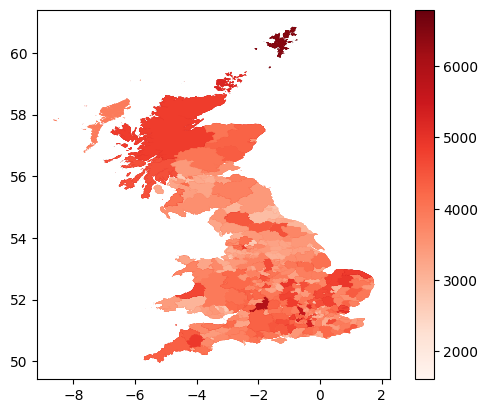

In [218]:
gdf_grouped_districts.plot(column='Mean_cons_kwh', legend=True, cmap="Reds")

In [ ]:
# TODO: Analysis